In [24]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from knunu_utils import * 

# Reinterpreting $B \to K \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [25]:
binning = np.linspace(0.0, 22.9, 8+1) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 22.9, 24+1)
# q2binning = np.linspace(0.0, 22.9, 1+1)

## Define the NP model in WC space

In [26]:
cvl = 14.0
cvr = 0.0
csl = 4.0
csr = 0.0
ctl = 1.0

## Compute number of samples to produce

In [27]:
# current lumi
lc = 362

# total lumi
lf = 50000

# current BB evts
ec = 387e6

# total BB evts
et = ec * lf / lc

## Generate some SM samples

In [28]:
p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->Knunu::BR', p, k, o)
SMBR = obs.evaluate()

# SMsamples = int(ec*SMBR)
SMsamples = int(et*SMBR)

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=8888))

In [29]:
# Smear samples with Gaussian resolution
np.random.seed(2222)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

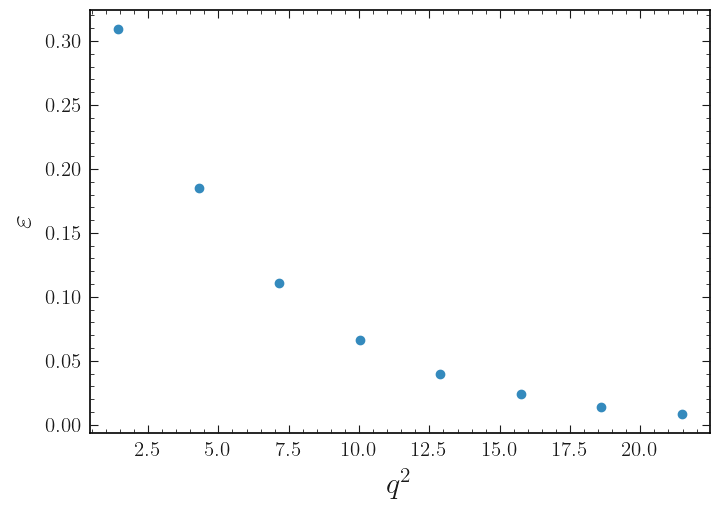

In [30]:
# plot efficiency
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [31]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)


BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=9999))

Pre-runs:  40%|████      | 2/5 [00:00<00:00,  7.47it/s]

In [32]:
# Smear samples with Gaussian resolution function
np.random.seed(4444)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

### Plot samples and calculate yields

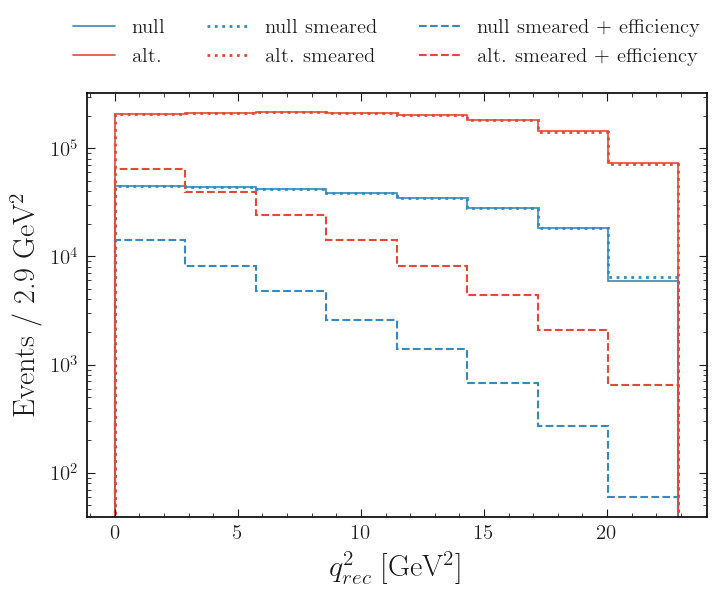

In [33]:
null_binned = np.histogram(null_samples, binning)[0]
alt_binned  = np.histogram(alt_samples,  binning)[0]

null_smeared_binned = np.histogram(null_samples_smeared, binning)[0]
alt_smeared_binned  = np.histogram(alt_samples_smeared,  binning)[0]

null_yields = np.histogram(null_samples_smeared, binning, weights = efficiency(null_samples_smeared))[0]
alt_yields  = np.histogram(alt_samples_smeared,  binning, weights = efficiency(alt_samples_smeared) )[0]

fig, ax = plt.subplots(1,1, sharex=True)

ax.stairs(null_binned, binning, color='C0', linewidth=1.2, linestyle='solid', label='null')
ax.stairs(alt_binned,  binning, color='C1', linewidth=1.2, linestyle='solid', label='alt.')
ax.stairs(null_smeared_binned, binning, color='C0', linewidth=2.0, linestyle='dotted', label='null smeared')
ax.stairs(alt_smeared_binned,  binning, color='C1', linewidth=2.0, linestyle='dotted', label='alt. smeared')
ax.stairs(null_yields, binning, label='null smeared + efficiency', color='C0', linewidth=1.5, linestyle='dashed')
ax.stairs(alt_yields,  binning, label='alt. smeared + efficiency', color='C1', linewidth=1.5, linestyle='dashed')

ax.set_xlabel(r'$q_{rec}^2$ [GeV$^2$]')
ax.set_ylabel(r'Events / 2.9 GeV$^2$')

ax.set_yscale('log')
ax.set_yscale('log')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

file = '../results/knunu_data_sets.pdf'
plt.savefig(file)

plt.show()

In [34]:
print('# SM samples', SMsamples)
print('# SM yields', sum(null_yields))
print('# BSM samples', BSMBR/SMBR * SMsamples)
print('# BSM yields', sum(alt_yields))
print('ratio BSM/SM samples', BSMBR/SMBR)
print('ratio BSM/SM yields', sum(alt_yields)/sum(null_yields))

# SM samples 257193
# SM yields 32109.999161779066
# BSM samples 1446849.0077089183
# BSM yields 157808.2300026605
ratio BSM/SM samples 5.625538050059365
ratio BSM/SM yields 4.914613332986368


## Set up the mapping distribution

In [35]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [36]:
null = null_pred()
alt = alt_pred()

In [37]:
ana = analysis()

fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [38]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000110,0.000707,0.001006,0.000781,0.001307,0.000092,0.000601,0.000818
1,0.000707,0.009453,0.021892,0.005759,0.010330,0.000451,0.006736,0.015675
2,0.001006,0.021892,0.067551,0.008672,0.017205,0.000232,0.012336,0.044533
3,0.000781,0.005759,0.008672,0.006255,0.011263,0.000648,0.005008,0.007014
4,0.001307,0.010330,0.017205,0.011263,0.021834,0.001043,0.008607,0.013407
5,0.000092,0.000451,0.000232,0.000648,0.001043,0.000474,0.003482,0.005928
6,0.000601,0.006736,0.012336,0.005008,0.008607,0.003482,0.032311,0.062863
7,0.000818,0.015675,0.044533,0.007014,0.013407,0.005928,0.062863,0.145980


In [39]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,),  'bounds': ((6., 16.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.001, ), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FFK'   :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='knunu')

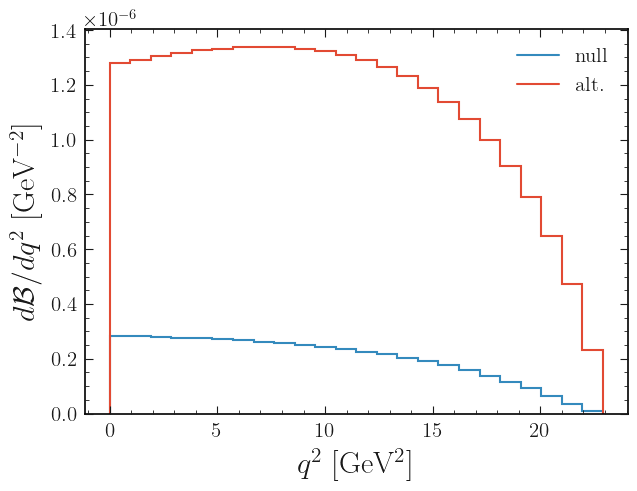

In [51]:
pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$ [GeV$^{-2}$]']
plot.dists(cmod, pars, lims, labels)
plt.savefig('../results/knunu_distributions.pdf')

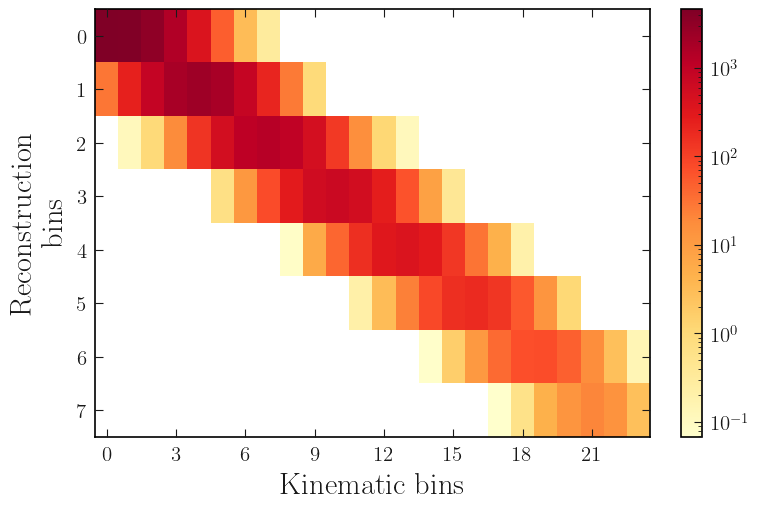

In [48]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm(), aspect='auto')
plt.savefig('../results/knunu_map.pdf')

## Set up the model

In [42]:
spec = {
  "channels": [
    {
      "name": "B->Knunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "knunu_theory",
                "type": "knunu",
                "data":{"expr": "knunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->Knunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->Knunu',
   'samples': [{'name': 'signal',
     'data': [14143.652589182999,
      8229.865753126196,
      4754.490786086884,
      2586.596339810312,
      1391.9668781627406,
      674.6691085977945,
      269.3203213515517,
      59.43738546058739],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [118.9270893832982,
        90.71860753520303,
        68.95281565017403,
        50.85859160270084,
        37.30907233050348,
        25.974393324922808,
        16.410981730279016,
        7.709564544161194]},
      {'name': 'knunu_theory',
       'type': 'knunu',
       'data': {'expr': 'knunu_weight_fn'}}]}]}]}

## Save and load model

In [43]:
modifier.save('knunu_model.json', model.spec, [cmod], alt_yields)
model, alt_yields = modifier.load('knunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [44]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']]  = [True]
fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

# for i in range(3, 8):
#     fixed[model.config.par_map[f'FFK_decorrelated[{i}]']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


/filer/z-sv-pool12c/l/Lorenz.Gaertner/micromamba/envs/redist/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


W MnPosDef Matrix forced pos-def by adding to diagonal 0.363621


{'cvl': array([13.9996317 ,  0.44713654]),
 'cvr': array([0.001, 0.   ]),
 'csl': array([4.12405026, 0.48154401]),
 'csr': array([0.001, 0.   ]),
 'ctl': array([1.0364821 , 1.36856371]),
 'FFK_decorrelated[0]': array([0.01075591, 0.98321897]),
 'FFK_decorrelated[1]': array([0.01673701, 0.97625578]),
 'FFK_decorrelated[2]': array([0.01231159, 1.0286931 ]),
 'FFK_decorrelated[3]': array([5.72680976e-04, 9.93792203e-01]),
 'FFK_decorrelated[4]': array([7.83696491e-04, 9.96867274e-01]),
 'FFK_decorrelated[5]': array([1.33345530e-04, 1.01423906e+00]),
 'FFK_decorrelated[6]': array([1.58030769e-04, 9.92305056e-01]),
 'FFK_decorrelated[7]': array([2.99543435e-04, 9.91310205e-01]),
 'mu': array([1., 0.]),
 'stat': [[0.9992557879037013, 0.00775896135247045],
  [1.0032708300067399, 0.007071755110650446],
  [0.9933160432105006, 0.009498834424511271],
  [1.008728232044185, 0.01271300271947412],
  [0.9962305525514336, 0.015813329516506602],
  [0.996160046677513, 0.02213051738144428],
  [0.996439576

In [45]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 13.999631703878126,
 'cvr': 0.001,
 'csl': 4.124050259269448,
 'csr': 0.001,
 'ctl': 1.03648210043146,
 'FFK[0]': 0.3379490008433432,
 'FFK[1]': -0.8861161511256945,
 'FFK[2]': -0.11657438877656527,
 'FFK[3]': 0.373991197706385,
 'FFK[4]': 0.07828858897704243,
 'FFK[5]': 0.3269813198229985,
 'FFK[6]': -0.9627401862890367,
 'FFK[7]': -0.2808302687398021,
 'mu': 1.0,
 'stat': [0.9992557879037013,
  1.0032708300067399,
  0.9933160432105006,
  1.008728232044185,
  0.9962305525514336,
  0.996160046677513,
  0.996439576743708,
  1.017828430419922]}

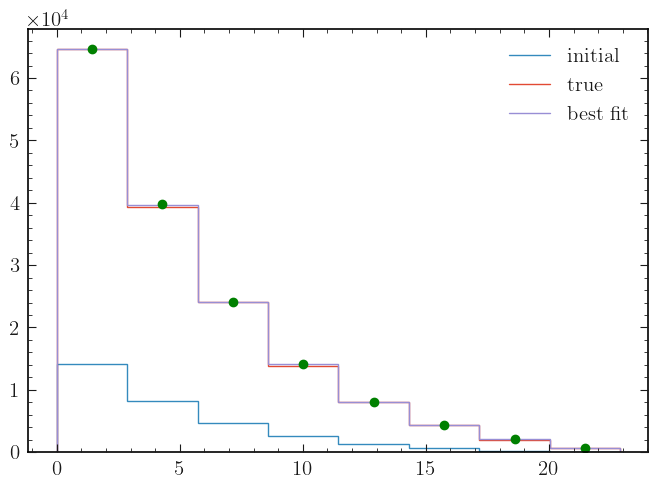

In [47]:
inits = model.config.suggested_init()
plt.stairs(model.expected_actualdata(inits), binning, label="initial")
inits[model.config.par_map['cvl']['slice']] = [14]
inits[model.config.par_map['csl']['slice']] = [4]
inits[model.config.par_map['ctl']['slice']] = [1]
plt.stairs(model.expected_actualdata(inits), binning, label="true")
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning, label = "best fit")
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')
plt.legend()